# Graph structure phase diagram
Phase diagram with number of edges and centralisation, all other parameters fixed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'classes'))

from news import News
from world import World
from utils import construct_agent_constant_parameters
from agent import AgentState

Function that builds the agents and graph.

In [2]:
def build_graph(num_nodes, number_of_additional_edges, centralisation):
    #make sure number_of_additional_edges edges can be added to the graph
    assert 2 * num_nodes + number_of_additional_edges <= num_nodes*(num_nodes - 1), 'not possible'

    # Nodes
    names = range(num_nodes)
    # Graph
    graph = nx.DiGraph()
    graph.add_nodes_from(names)

    # Connect agents in a Circle in both directions so graph is connected
    if num_nodes > 1:
        graph.add_edge(names[0], names[-1])
        graph.add_edge(names[-1], names[0])
        if num_nodes > 2:
            for i in range(num_nodes - 1):
                graph.add_edge(names[i], names[i + 1])
                graph.add_edge(names[i + 1], names[i])

    # Add additional edges according to centralisation
    current_information_provider = None
    for n in range(number_of_additional_edges):
        if n==0:
            # Choose provider and receiver randomly
            current_information_provider = np.random.choice(names)
            information_receiver = np.random.choice([a for a in names if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))])
            graph.add_edge(current_information_provider, information_receiver)
        else:
            # Change provider with Probability 1 - centralisation
            if np.random.random() > centralisation:
                current_information_provider = np.random.choice([a for a in names if a != current_information_provider])
            # Make sure receiver can be selected
            while len([a for a in names if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))]) == 0:
                current_information_provider = np.random.choice([a for a in names if a != current_information_provider])
            #Choose receiver randomly
            information_receiver = np.random.choice([a for a in names if (a != current_information_provider and (not graph.has_edge(current_information_provider, a)))])
            graph.add_edge(current_information_provider, information_receiver)

    # Set weights on edges
    for node in graph.nodes():
        # Set out-degree as weight on out-going edges
        out_degree = graph.out_degree[node]
        for edge in graph.edges(node):
            graph.edges[edge]['weight'] = out_degree

    # Normalize over in-going edges
    for node in graph.nodes():
        sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))
        for edge in graph.in_edges(node):
            graph.edges[edge]['weight'] /= sum_ingoing

    return graph

Define function which generates a matrix with percentages of how many agents shared the news for different values of `number_of_additional_edges` and `centralisation`.

In [3]:
def generate_share_map(num_bins=51, factor_for_number_of_additional_edges=10, num_agents=100, sensation=1.0, threshold=0.5, independence=0.5,truth_weight=0.5, graph_samples=10):

    assert 2 * num_agents + (num_bins - 1) * factor_for_number_of_additional_edges <= num_agents*(num_agents - 1), 'not possible'

    numbers_of_additional_edges = np.arange(num_bins) * factor_for_number_of_additional_edges
    centralisation_values = np.linspace(0, 1, num_bins)

    df = pd.DataFrame(columns=['additional edges', 'centralisation', 'number shared'])

    print(f'Starting simulation with {num_agents} agents (this may take some time...)')
    for number_of_additional_edges in numbers_of_additional_edges:
        for centralisation in centralisation_values:
            number_samples = []
            for g_nmb in range(graph_samples):
                graph = build_graph(num_agents, number_of_additional_edges, centralisation)
                news = {1: News(1, sensation, decay_parameter=0.0)}
                agents = construct_agent_constant_parameters(num_agents, threshold, independence, news, graph)
                world = World(agents, news, graph)

                # Activate random agent
                agent = np.random.choice(list(world.agents.values()))
                agent.states[1] = AgentState.ACTIVE

                number_active, _, _ = world.full_dynamics(max_iter=20)

                number_samples.append(number_active / num_agents)

            num_sharing = pd.DataFrame([[number_of_additional_edges, centralisation, np.mean(number_samples)]], columns=df.columns)
            df = df.append(num_sharing, ignore_index=True)
        print(number_of_additional_edges/ (num_bins - 1) / factor_for_number_of_additional_edges)

    print('Simulation completed!!!')

    return df.astype(float).pivot('additional edges', 'centralisation', 'number shared')

### Share Maps

# Different thresholds

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

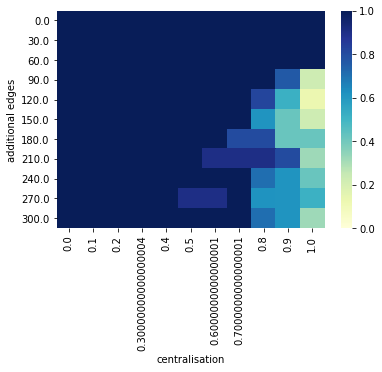

In [4]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.25, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

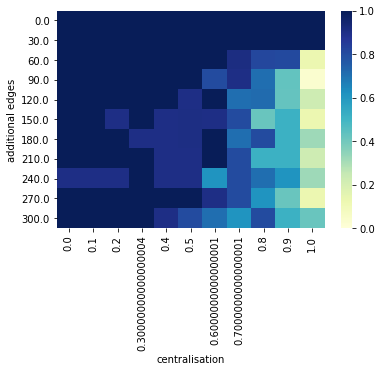

In [5]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

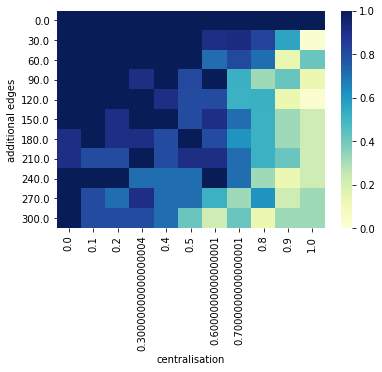

In [6]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.75, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

# Different independences

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

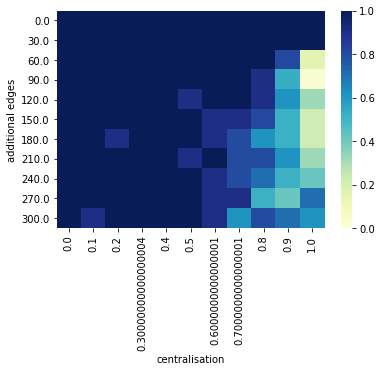

In [7]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.5, independence=0.25,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

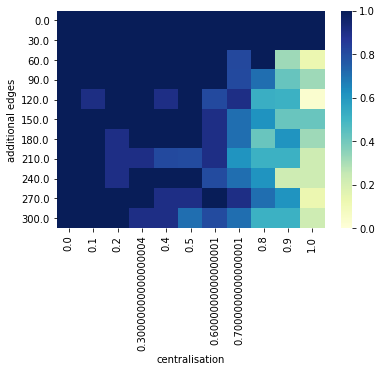

In [8]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

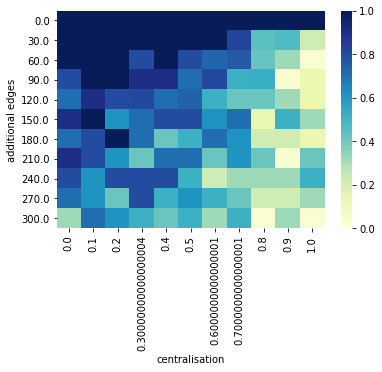

In [9]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.5, independence=0.75,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

# Different truth_weights

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

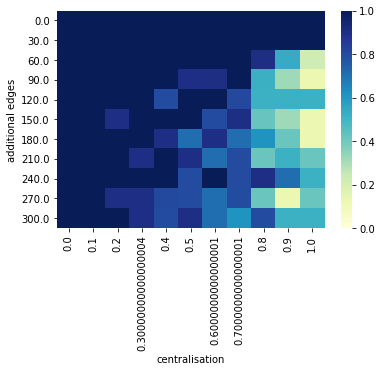

In [10]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.25, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

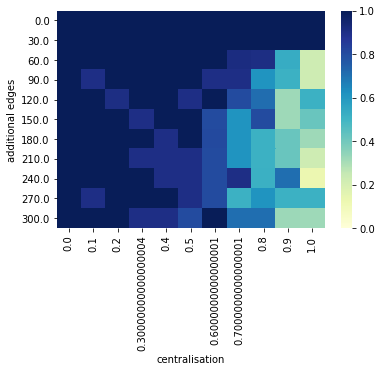

In [11]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

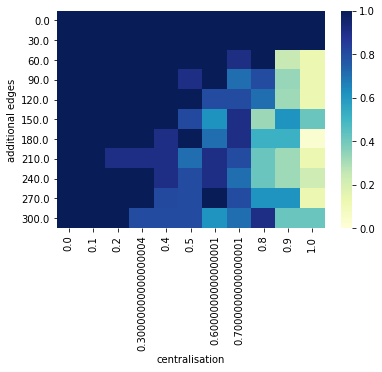

In [12]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.75, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

# Different sensation

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

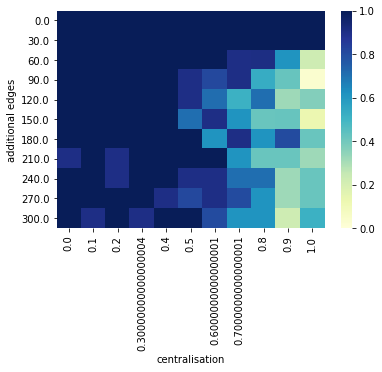

In [13]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.95, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)


Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

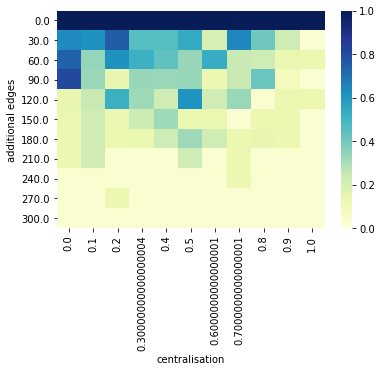

In [14]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.75, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

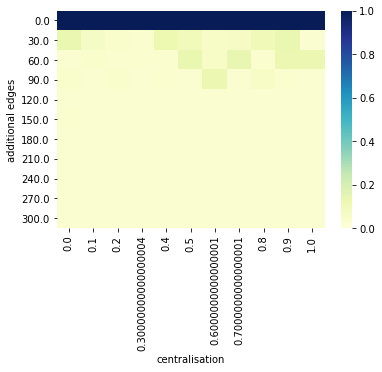

In [15]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.5, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

Starting simulation with 30 agents (this may take some time...)
0.0


<ipython-input-2-0948fb39670f>:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_ingoing = np.sum(attr['weight'] for a, b, attr in graph.in_edges(node, data=True))


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Simulation completed!!!


<AxesSubplot:xlabel='centralisation', ylabel='additional edges'>

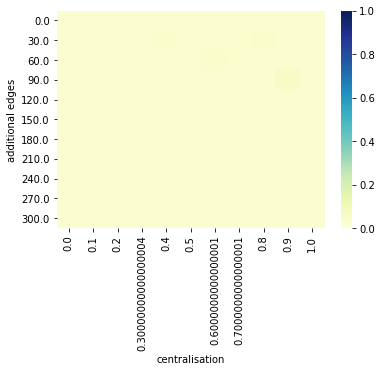

In [16]:
share_map = generate_share_map(factor_for_number_of_additional_edges=30, num_agents=30, sensation=0.25, threshold=0.5, independence=0.5,truth_weight=0.5, num_bins=11)
sns.heatmap(share_map, cmap='YlGnBu', vmin=0.0, vmax=1.0)

For a simple circle (no additional edges) the weight for the adjacent nodes is always 0.5, so it will spread as likely as possible for a strongly connected graph, but as slow as possible.

For a high concentration, the nodes with a high number of out-going edges will have a high weight, so the news will only spread if the news starts there and then it will spread fast.

For a low concentration, all nodes will have similar out-degree and therefore similar weight, news spreading depends on the number of nodes, with a low number the news spreads fast, with a high number
the weight will be too low.